In [10]:
#All of the imports
import sionna.rt
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import drjit as dr
import mitsuba as mi
from typing import Tuple, List
import random 

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies

from tabulate import tabulate


using_preview = True


In [11]:
import warnings
from sionna.rt.utils import watt_to_dbm, log10, rotation_matrix
from sionna.rt.constants import DEFAULT_TRANSMITTER_COLOR,\
    DEFAULT_RECEIVER_COLOR
#Adding summing capabilities (mostly copied from sionna source code)
def show_sum(
    self,
    metric : str = "path_gain",
    tx : int | None = None,
    vmin : float | None = None,
    vmax : float | None = None,
    show_tx : bool = True,
    show_rx : bool = False
    ) -> plt.Figure:

    tx_cell_indices = self.tx_cell_indices
    rx_cell_indices = self.rx_cell_indices
    
    tensor = sum_radio_map(self, metric)

    # Convert to dB-scale
    if metric in ["path_gain", "sinr"]:
        with warnings.catch_warnings(record=True) as _:
            # Convert the path gain to dB
            tensor = 10.*log10(tensor)
    else:
        with warnings.catch_warnings(record=True) as _:
            # Convert the signal strengmth to dBm
            tensor = watt_to_dbm(tensor)

    # Set label
    if metric == "path_gain":
        colorbar_label = "Path gain [dB]"
        title = "Path gain"
    elif metric == "rss":
        colorbar_label = "Received signal strength (RSS) [dBm]"
        title = 'RSS'
    else:
        colorbar_label = "Signal-to-interference-plus-noise ratio (SINR)"\
                            " [dB]"
        title = 'SINR'

    # Visualization the radio map
    fig_cm = plt.figure()
    plt.imshow(tensor.numpy(), origin='lower', vmin=vmin, vmax=vmax)

    # Set label
    if (tx is None) & (self.num_tx > 1):
        title = 'Sum ' + title + ' across all TXs'
    elif tx is not None:
        title = title + f" for TX '{tx}'"
    plt.colorbar(label=colorbar_label)
    plt.xlabel('Cell index (X-axis)')
    plt.ylabel('Cell index (Y-axis)')
    plt.title(title)

    # Show transmitter, receiver
    if show_tx:
        if tx is not None:
            fig_cm.axes[0].scatter(tx_cell_indices.x[tx],
                                    tx_cell_indices.y[tx],
                                    marker='P',
                                    color=(0,0,0))
        else:
            for tx_ in range(self.num_tx):
                fig_cm.axes[0].scatter(tx_cell_indices.x[tx_],
                                        tx_cell_indices.y[tx_],
                                        marker='P',
                                        color=(0,0,0))

    if show_rx:
        for rx in range(self.num_rx):
            fig_cm.axes[0].scatter(rx_cell_indices.x[rx],
                                    rx_cell_indices.y[rx],
                                    marker='x',
                                    color=DEFAULT_RECEIVER_COLOR)

    return fig_cm

def sum_radio_map(
    self,
    metric : str = "path_gain",
    ) -> mi.TensorXf:
    r"""Returns the radio map values corresponding to transmitter ``tx``
    and a specific ``metric``

    If ``tx`` is `None`, then returns for each cell the maximum value
    accross the transmitters.

    :param metric: Metric for which to return the radio map
    :type metric: "path_gain" | "rss" | "sinr"
    """

    if metric not in ["path_gain", "rss", "sinr"]:
        raise ValueError("Invalid metric")
    tensor = getattr(self, metric)


    # Select metric for a specific transmitter or compute max
    
    tensor = dr.sum(tensor, axis=0)

    return tensor

def sum_cdf(
    self,
    metric : str = "path_gain",
    tx : int | None = None,
    bins : int = 200
    ) -> Tuple[plt.Figure, mi.TensorXf, mi.Float]:
    r"""Computes and visualizes the CDF of a metric of the radio map

    :param metric: Metric to be shown
    :type metric: "path_gain" | "rss" | "sinr"

    :param tx: Index or name of the transmitter for which to show the radio
        map. If `None`, the maximum value over all transmitters for each
        cell is shown.

    :param bins: Number of bins used to compute the CDF

    :return: Figure showing the CDF

    :return: Data points for the chosen metric

    :return: Cummulative probabilities for the data points
    """

    tensor = sum_radio_map(self, metric)
    # Flatten tensor
    tensor = dr.ravel(tensor)

    if metric in ["path_gain", "sinr"]:
        with warnings.catch_warnings(record=True) as _:
            # Convert the path gain to dB
            tensor = 10.*log10(tensor)
    else:
        with warnings.catch_warnings(record=True) as _:
            # Convert the signal strengmth to dBm
            tensor = watt_to_dbm(tensor)

    # Compute the CDF

    # Cells with no coverage are excluded
    active = tensor != float("-inf")
    num_active = dr.count(active)
    # Compute the range
    max_val = dr.max(tensor)
    if max_val == float("inf"):
        raise ValueError("Max value is infinity")
    tensor_ = dr.select(active, tensor, float("inf"))
    min_val = dr.min(tensor_)
    range_val = max_val - min_val
    # Compute the cdf
    ind = mi.UInt(dr.floor((tensor - min_val)*bins/range_val))
    cdf = dr.zeros(mi.UInt, bins)
    dr.scatter_inc(cdf, ind, active)
    cdf = mi.Float(dr.cumsum(cdf))
    cdf /= num_active
    # Values
    x = dr.arange(mi.Float, 1, bins+1)/bins*range_val + min_val

    # Plot the CDF

    fig, _ = plt.subplots()
    plt.plot(x.numpy(), cdf.numpy())
    plt.grid(True, which="both")
    plt.ylabel("Cummulative probability")

    # Set x-label and title
    if metric=="path_gain":
        xlabel = "Path gain [dB]"
        title = "Path gain"
    elif metric=="rss":
        xlabel = "Received signal strength (RSS) [dBm]"
        title = "RSS"
    else:
        xlabel = "Signal-to-interference-plus-noise ratio (SINR) [dB]"
        title = "SINR"
    if (tx is None) & (self.num_tx > 1):
        title = 'Sum ' + title + ' across all TXs'
    elif tx is not None:
        title = title + f' for TX {tx}'

    plt.xlabel(xlabel)
    plt.title(title)

    return fig, x, cdf


def concat_point3f(a, b) -> mi.Point3f:
    total = [[],[],[]]

    for i in range(len(a[0])):
        total[0].append(a[0][i])
        total[1].append(a[1][i])
        total[2].append(a[2][i])

    for i in range(len(b[0])):
        total[0].append(b[0][i])
        total[1].append(b[1][i])
        total[2].append(b[2][i])

    return mi.Point3f(total)

import matplotlib as mpl
from matplotlib.colors import from_levels_and_colors

def show_association_more_colours(
        self,
        metric : str = "path_gain",
        show_tx : bool = True,
        show_rx : bool = False
        ) -> plt.Figure:
        r"""Visualizes cell-to-tx association for a given metric

        The positions of the transmitters and receivers are indicated
        by "+" and "x" markers, respectively.

        :param metric: Metric to show
        :type metric: "path_gain" | "rss" | "sinr"

        :param show_tx: If set to `True`, then the position of the transmitters
            are shown.

        :param show_rx: If set to `True`, then the position of the receivers are
            shown.

        :return: Figure showing the cell-to-transmitter association
        """

        tx_cell_indices = self.tx_cell_indices
        rx_cell_indices = self.rx_cell_indices

        if metric not in ["path_gain", "rss", "sinr"]:
            raise ValueError("Invalid metric")

        # Create the colormap and normalization
        colors = mpl.colormaps['tab20'].colors[:self.num_tx]
        cmap, norm = from_levels_and_colors(
            list(range(self.num_tx+1)), colors)
        fig_tx = plt.figure()
        plt.imshow(self.tx_association(metric).numpy(),
                    origin='lower', cmap=cmap, norm=norm)
        plt.xlabel('Cell index (X-axis)')
        plt.ylabel('Cell index (Y-axis)')
        plt.title('Cell-to-TX association')
        cbar = plt.colorbar(label="TX")
        cbar.ax.get_yaxis().set_ticks([])
        for tx in range(self.num_tx):
            cbar.ax.text(.5, tx + .5, str(tx), ha='center', va='center')

        # Show transmitter, receiver
        if show_tx:
            for tx in range(self.num_tx):
                fig_tx.axes[0].scatter(tx_cell_indices.x[tx],
                                       tx_cell_indices.y[tx],
                                       marker='P',
                                       color=(0,0,0))

        if show_rx:
            for rx in range(self.num_rx):
                fig_tx.axes[0].scatter(rx_cell_indices.x[rx],
                                       rx_cell_indices.y[rx],
                                       marker='x',
                                       color=DEFAULT_RECEIVER_COLOR)

        return fig_tx


In [ ]:
#Functions for calculating related power collection metrics after generating the data 

class RF_harvesting_metrics:
    def __init__(self, _median_energy_RX, _median_energy_DC, _median_charging_time, _first_qart_RX, _third_quart_RX, _mean_energy_RX, _mean_energy_DC, _mean_charging_time, _pdf_power_values, _pdf_values):
        self.median_energy_RX = _median_energy_RX
        self.median_energy_DC = _median_energy_DC
        self.median_charging_time = _median_charging_time
        self.mean_energy_RX = _mean_energy_RX
        self.mean_energy_DC = _mean_energy_DC
        self.mean_charging_time = _mean_charging_time
        self.pdf_power_values = _pdf_power_values
        self.pdf_values = _pdf_values 
        self.first_qart_RX = _first_qart_RX
        self.third_quart_RX = _third_quart_RX   

    def print_related_values(self):
        first_quart_DC = power_recieved_dbm(self.first_qart_RX)
        first_quart_time = calculate_time_from_db(first_quart_DC)

        third_quart_DC = power_recieved_dbm(self.third_quart_RX)
        third_quart_time = calculate_time_from_db(third_quart_DC)

        print(tabulate([['Mean', self.mean_energy_RX, self.mean_energy_DC, self.mean_charging_time], 
                        ['Q1', self.first_qart_RX, first_quart_DC, first_quart_time],
                        ['Median', self.median_energy_RX, self.median_energy_DC, self.median_charging_time],
                        ['Q3', third_quart_DC, self.median_energy_DC, third_quart_time]], 
                        headers=['Type', 'RX energy (dbm)', 'DC energy (dbm)', 'time (s)'], 
                        tablefmt='orgtbl'))
        
    def display_cdf_and_pdf(self, cdf_values):
        #CDF is already set to show
        plt.show()

        plt.plot(self.pdf_power_values, self.pdf_values, color='red')
        plt.ylabel("PDF")
        plt.xlabel("energy RX (dB)")
        plt.show()


def calculate_slope(x1, y1, x2, y2):
    return (y2 - y1)/(x2 - x1)


#constants
C = 0.0001 #capacitance
V = 1.8 #voltage
R = 0.1 #series resistance

psens = 0.000001 #(dbm)
psat = 0.001 #(dbm)
a = 42300
b = 5.2

#Calculating Power Recieved
def DC_power_recieved(input_power):
    psig = 1 + np.exp(-a * psens + b)
    psig /= 1 + np.exp(-a*input_power + b)
    psig -= 1
    psig *= psat/np.exp(-a * psens + b) 

    if(psig < 0):
        psig = 0

    return psig

def power_recieved_dbm(input_power):
    power_W = math.pow(10, input_power/10)/1000
    power_W = DC_power_recieved(power_W)
    if(power_W == 0):
        return -140
    else:
        return 10 * math.log(1000 * power_W)
    

def calculate_time(input_power): #(Basically just equivelent to total stored energy of a capacitor / input power)
    A = math.sqrt(C*C*V*V + 4 * C*C * R * input_power)
    t = math.log((A + C * V)/(A - C * V))
    t += (2 * C * V)/(A - C * V)
    t *= 0.5 * R * C
    return t

def calculate_time_from_db(power_db):
    power_W = math.pow(10, power_db/10)/1000
    return calculate_time(power_W)

def calculate_metrics_from_cdf(cdf_values) -> RF_harvesting_metrics:
    PDF_x_values = []
    PDF_y_values = []

    for i in range(len(cdf_values[1])-1):
        PDF_x_values.append(cdf_values[1][i])

    for i in range(len(cdf_values[1]) - 1):
        slope = calculate_slope(cdf_values[1][i], cdf_values[2][i], cdf_values[1][i+1], cdf_values[2][i+1])
        PDF_y_values.append(slope)


    #Calculating median RX energy and related values
    median_energy_RX = 0
    Q1_energy_RX = 0
    Q3_energy_RX = 0

    found_Q1 = False
    found_median = False
    


    for i in range(len(cdf_values[2])):
        if(not found_Q1):
            if(cdf_values[2][i] >= 0.25):
                found_Q1 = True
                Q1_energy_RX = cdf_values[1][i]

        if(not found_median):
            if (cdf_values[2][i] >= 0.5):
                found_median = True
                median_energy_RX = cdf_values[1][i]
        
        if(cdf_values[2][i] >= 0.75):
            Q3_energy_RX = cdf_values[1][i]
            break
                

    median_energy_DC = power_recieved_dbm(median_energy_RX)
    median_charging_time = calculate_time_from_db(median_energy_DC)

    #Calculating mean RX energy and related values
    area_accumulator = 0
    for i in range(len(PDF_y_values)-1):
        area = 0.5 * (PDF_x_values[i+1] - PDF_x_values[i]) * (PDF_y_values[i+1] * PDF_x_values[i+1] + PDF_y_values[i] * PDF_x_values[i]) 
        area_accumulator += area

    mean_energy_RX = area_accumulator

    mean_energy_DC = power_recieved_dbm(mean_energy_RX)
    mean_charging_time = calculate_time_from_db(mean_energy_DC)

    #Returns class containing the values
    return RF_harvesting_metrics(median_energy_RX, median_energy_DC, median_charging_time, Q1_energy_RX, Q3_energy_RX, mean_energy_RX, mean_energy_DC, mean_charging_time, PDF_x_values, PDF_y_values)




| Type   |   RX energy (dbm) |   DC energy (dbm) |   time (s) |
|--------+-------------------+-------------------+------------|
| Mean   |         -10.0873  |         -13.6984  |    3.79633 |
| Median |          -8.76736 |          -5.09508 |    0.52369 |


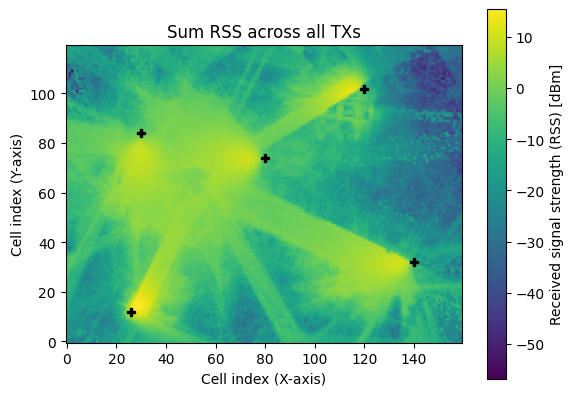

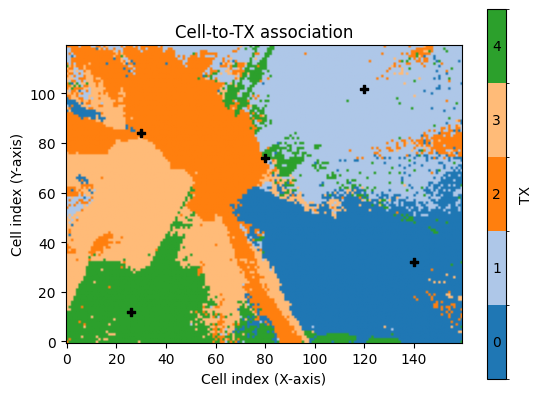

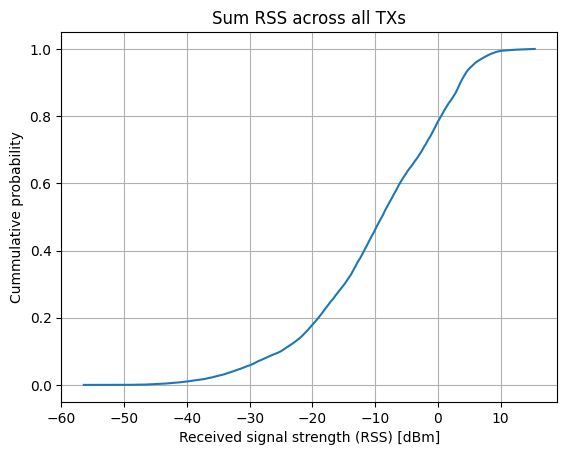

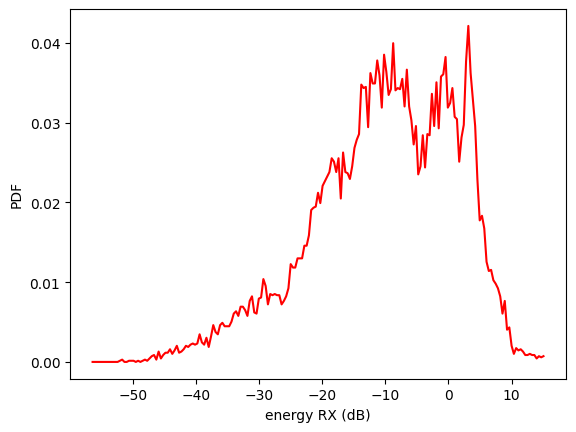

In [13]:
##TEST #1: ETIOLE w/ 5 tr38901 (directed) antennas
current_scene = load_scene(sionna.rt.scene.etoile)
current_scene.frequency = 3e9
current_scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1, 
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

transmitters = []

transmitters.append(Transmitter(name="tx1", position=[300,-130,25], display_radius=10, power_dbm=80))
transmitters[-1].look_at([298,-130,25])
current_scene.add(transmitters[-1])

transmitters.append(Transmitter(name="tx2", position=[200,220,35], display_radius=10, power_dbm=80))
transmitters[-1].look_at([190,215,25])
current_scene.add(transmitters[-1])

transmitters.append(Transmitter(name="tx3", position=[0,80,27], display_radius=10, power_dbm=80))
transmitters[-1].look_at([-10,80,27])
current_scene.add(transmitters[-1])

transmitters.append(Transmitter(name="tx4", position=[-250,130,29], display_radius=10, power_dbm=80))
transmitters[-1].look_at([-250, 120, 29])
current_scene.add(transmitters[-1])

transmitters.append(Transmitter(name="tx5", position=[-270,-230,27], display_radius=10, power_dbm=80))
transmitters[-1].look_at([-268,-228,25])
current_scene.add(transmitters[-1])

rm_solver = RadioMapSolver()
rm = rm_solver(current_scene,
               max_depth=30,           # Maximum number of ray scene interactions
               samples_per_tx=10**7 , # If you increase: less noise, but more memory required
               cell_size=(5, 5),      # Resolution of the radio map
               center=[0, 10, 1],      # Center of the radio map
               size=[800, 600],       # Total size of the radio map
               orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical



show_sum(rm, metric="rss")
show_association_more_colours(rm)
cdf_values = sum_cdf(rm, metric="rss");
metrics = calculate_metrics_from_cdf(cdf_values)
metrics.print_related_values()
metrics.display_cdf_and_pdf(cdf_values)
current_scene.preview(radio_map=rm);

| Type   |   RX energy (dbm) |   DC energy (dbm) |   time (s) |
|--------+-------------------+-------------------+------------|
| Mean   |         -10.0873  |         -13.6984  |    3.79633 |
| Median |          -8.76736 |          -5.09508 |    0.52369 |


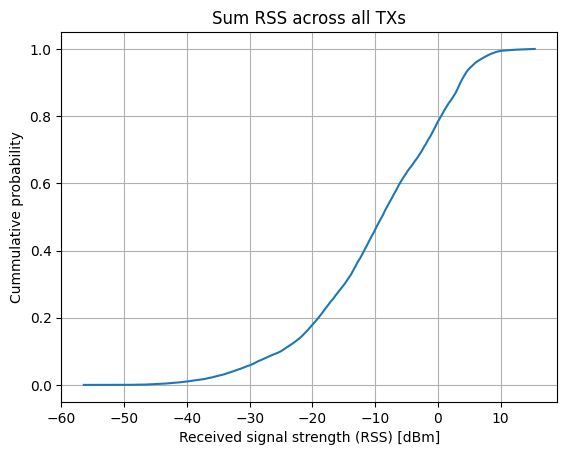

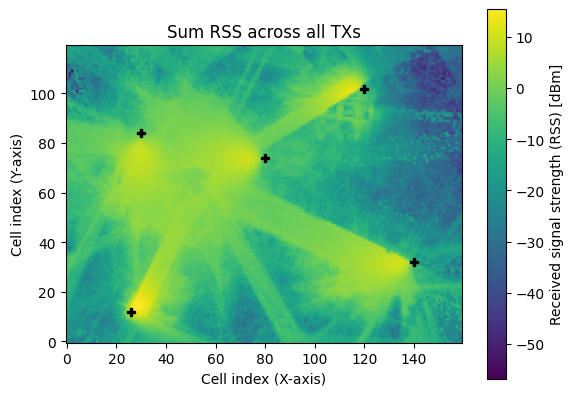

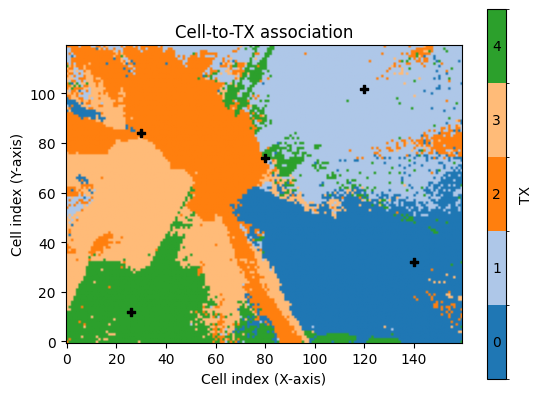

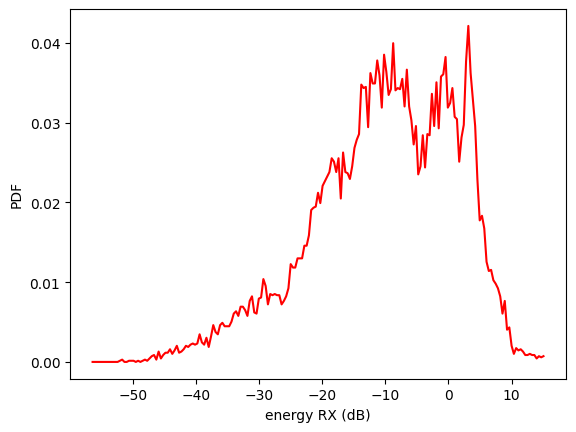

In [14]:
## Test #2: ETOILE w/ 6 dipole antennas
current_scene = load_scene(sionna.rt.scene.etoile)
current_scene.frequency = 3e9
current_scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1, 
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

transmitters = []

transmitters.append(Transmitter(name="tx3", position=[240,-100,25], display_radius=10, power_dbm=80))
current_scene.add(transmitters[-1])

transmitters.append(Transmitter(name="tx4", position=[-50,-190,31], display_radius=10, power_dbm=80))
current_scene.add(transmitters[-1])

transmitters.append(Transmitter(name="tx5", position=[200,220,35], display_radius=10, power_dbm=80))
current_scene.add(transmitters[-1])

transmitters.append(Transmitter(name="tx6", position=[0,80,27], display_radius=10, power_dbm=80))
current_scene.add(transmitters[-1])

transmitters.append(Transmitter(name="tx7", position=[-250,130,29], display_radius=10, power_dbm=80))
current_scene.add(transmitters[-1])

transmitters.append(Transmitter(name="tx8", position=[-290,-210,27], display_radius=10, power_dbm=80))
current_scene.add(transmitters[-1])

rm_solver = RadioMapSolver()
rm_dipole = rm_solver(current_scene,
               max_depth=30,           # Maximum number of ray scene interactions
               samples_per_tx=10**7 , # If you increase: less noise, but more memory required
               cell_size=(5, 5),      # Resolution of the radio map
               center=[0, 10, 1],      # Center of the radio map
               size=[800, 600],       # Total size of the radio map
               orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical

cdf_values = sum_cdf(rm, metric="rss")
show_sum(rm, metric="rss")
show_association_more_colours(rm)

metrics = calculate_metrics_from_cdf(cdf_values)
metrics.print_related_values()
metrics.display_cdf_and_pdf(cdf_values)

current_scene.preview(radio_map=rm);



| Type   |   RX energy (dbm) |   DC energy (dbm) |   time (s) |
|--------+-------------------+-------------------+------------|
| Mean   |          -12.8539 |          -31.7951 |   244.92   |
| Median |          -12.152  |          -27.7551 |    96.6102 |


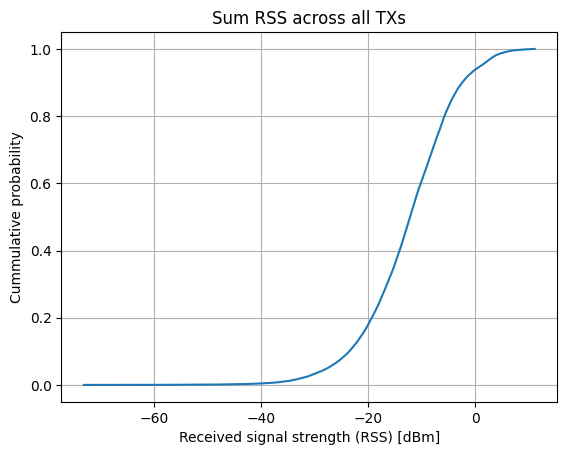

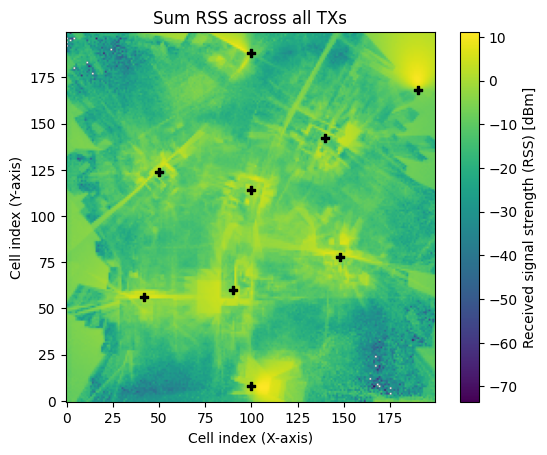

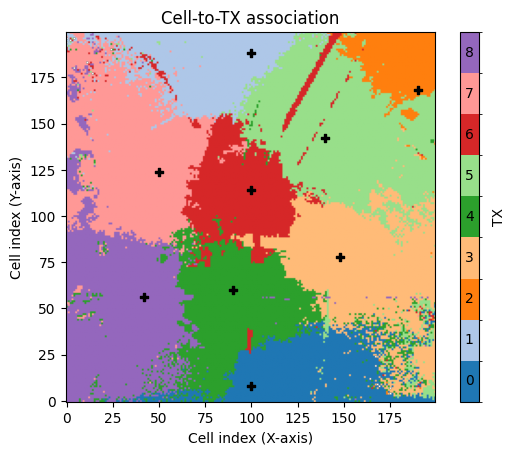

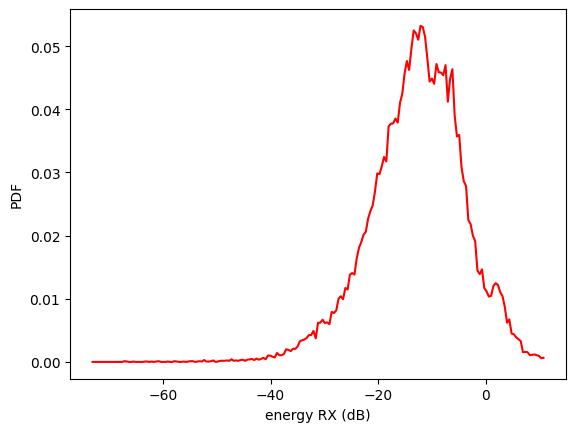

In [15]:
##TEST #3: Florence with dipole antennas and directive antennas
current_scene = load_scene(sionna.rt.scene.florence)
current_scene.frequency = 3e9
current_scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1, 
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

transmitters = []

transmitters.append(Transmitter(name="tx3", position=[240,-100,25], display_radius=10, power_dbm=80))
current_scene.add(transmitters[-1])

transmitters.append(Transmitter(name="tx4", position=[-50,-190,31], display_radius=10, power_dbm=80))
current_scene.add(transmitters[-1])

transmitters.append(Transmitter(name="tx5", position=[200,220,35], display_radius=10, power_dbm=80))
current_scene.add(transmitters[-1])

transmitters.append(Transmitter(name="tx6", position=[0,80,27], display_radius=10, power_dbm=80))
current_scene.add(transmitters[-1])

transmitters.append(Transmitter(name="tx7", position=[-250,130,29], display_radius=10, power_dbm=80))
current_scene.add(transmitters[-1])

transmitters.append(Transmitter(name="tx8", position=[-290,-210,27], display_radius=10, power_dbm=80))
current_scene.add(transmitters[-1])

rm_solver = RadioMapSolver()
rm_dipole = rm_solver(current_scene,
               max_depth=30,           # Maximum number of ray scene interactions
               samples_per_tx=10**7 , # If you increase: less noise, but more memory required
               cell_size=(5, 5),      # Resolution of the radio map
               center=[0, 10, 1],      # Center of the radio map
               size=[1000, 1000],       # Total size of the radio map
               orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical


current_scene = load_scene(sionna.rt.scene.florence)
current_scene.frequency = 3e9
current_scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1, 
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")


previous_transmitters = transmitters
transmitters = []

transmitters.append(Transmitter(name="tx0", position=[0,-450,25], display_radius=10, power_dbm=80))
transmitters[-1].look_at([1,-450, 25])
current_scene.add(transmitters[-1])

transmitters.append(Transmitter(name="tx1", position=[0,450,25], display_radius=10, power_dbm=80))
transmitters[-1].look_at([-1,450, 25])
current_scene.add(transmitters[-1])

transmitters.append(Transmitter(name="tx2", position=[450,350,25], display_radius=10, power_dbm=80))
transmitters[-1].look_at([450,351, 25])
current_scene.add(transmitters[-1])

rm = rm_solver(current_scene,
               max_depth=30,           # Maximum number of ray scene interactions
               samples_per_tx=10**7 , # If you increase: less noise, but more memory required
               cell_size=(5, 5),      # Resolution of the radio map
               center=[0, 10, 1],      # Center of the radio map
               size=[1000, 1000],       # Total size of the radio map
               orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical



#requires a concat function in drjit (I copied this manually from an example pull request online)
rm._pathgain_map = dr.concat([rm._pathgain_map, rm_dipole._pathgain_map], 0)
rm._tx_positions = concat_point3f(rm._tx_positions, rm_dipole._tx_positions)
rm._tx_powers = dr.concat([rm._tx_powers, rm_dipole._tx_powers], 0)

cdf_values = sum_cdf(rm, metric="rss")
show_sum(rm, metric="rss")
show_association_more_colours(rm)

metrics = calculate_metrics_from_cdf(cdf_values)
metrics.print_related_values()
metrics.display_cdf_and_pdf(cdf_values)

#Adds the previous transmitters back in for the preview
for p in previous_transmitters:
    current_scene.add(p)
current_scene.preview(radio_map=rm);

| Type   |   RX energy (dbm) |   DC energy (dbm) |   time (s) |
|--------+-------------------+-------------------+------------|
| Mean   |          -15.2631 |          -43.1148 |   3318.93  |
| Median |          -13.9214 |          -37.2343 |    856.922 |


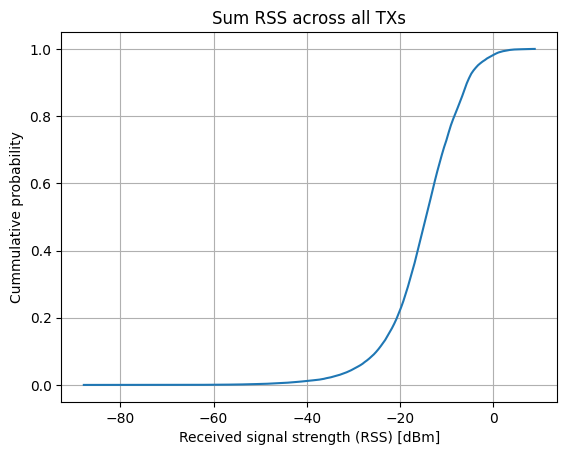

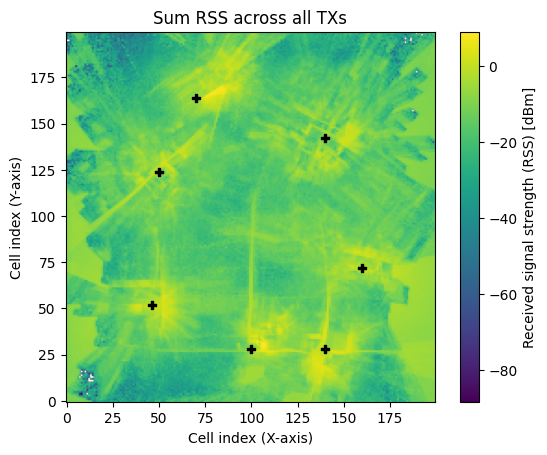

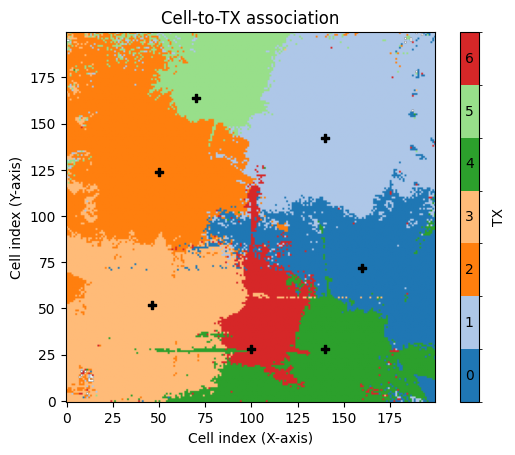

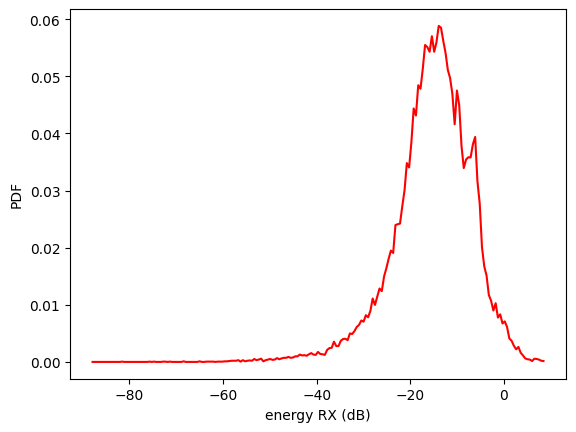

In [16]:
##TEST #4: Florence with rotating directive antennas
current_scene = load_scene(sionna.rt.scene.florence)
current_scene.frequency = 3e9
current_scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1, 
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

num_iterations = 10
angle_delta = (2*math.pi)/num_iterations

transmitters = []

positions_array = [[300,-130,25], 
             [200,220,35],
             [-250,130,29],
             [-270,-230,27],
             [200,-350,27],
             [-150,330,27],
             [0, -350, 27]]

for i,_position in enumerate(positions_array):
    transmitters.append(Transmitter(name=f"tx{i}", position=_position, display_radius=10, power_dbm=80))
    transmitters[-1].orientation = (random.random(), 0, 0)
    current_scene.add(transmitters[-1])

rm_solver = RadioMapSolver()
rm = rm_solver(current_scene,
               max_depth=30,           # Maximum number of ray scene interactions
               samples_per_tx=10**7 , # If you increase: less noise, but more memory required
               cell_size=(5, 5),      # Resolution of the radio map
               center=[0, 10, 1],      # Center of the radio map
               size=[1000, 1000],       # Total size of the radio map
               orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical


for i in range(num_iterations-1):
    #rotate transmitters
    for j in range(5):
        current_scene.get(f"tx{j}").orientation += (angle_delta, 0, 0)

    radio_map = rm_solver(current_scene,
               max_depth=30,           # Maximum number of ray scene interactions
               samples_per_tx=10**7 , # If you increase: less noise, but more memory required
               cell_size=(5, 5),      # Resolution of the radio map
               center=[0, 10, 1],      # Center of the radio map
               size=[1000, 1000],       # Total size of the radio map
               orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical
    
    rm._pathgain_map += radio_map._pathgain_map

rm._pathgain_map /= num_iterations

cdf_values = sum_cdf(rm, metric="rss")
show_sum(rm, metric="rss")
show_association_more_colours(rm)

metrics = calculate_metrics_from_cdf(cdf_values)
metrics.print_related_values()
metrics.display_cdf_and_pdf(cdf_values)

current_scene.preview(radio_map = rm);

In [17]:
##TEST #5: Munich with beamforming directive antennas
num_cols = 64 #Shape of the beam is directly impacted by the number of antenna elements. 64 seems to preduce a pretty sharp result

current_scene = load_scene(sionna.rt.scene.munich)
current_scene.frequency = 3e9
current_scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=num_cols, 
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

transmitters = []

positions_array = [
    [450, -195, 25],
    [300, 200, 35],
    [75, -150, 27],
    [-490, 195, 29],
    [-470, -345, 27],
    [300, -345, 27],
    [-225, 0, 27],
    [0, -500, 27]
]

for i,_position in enumerate(positions_array):
    transmitters.append(Transmitter(name=f"tx{i}", position=_position, display_radius=10, power_dbm=80))
    transmitters[-1].orientation = (random.random(), 0, 0)
    current_scene.add(transmitters[-1])

num_iterations = 100
steering_angle = 0

def compute_precoding_vector(steering_angle):
    enumerated = np.arange(num_cols)
    enumerated = np.exp(1j*np.pi*enumerated*np.sin(steering_angle))
    enumerated /= np.sqrt(num_cols)

    return [dr.auto.ad.TensorXf(enumerated.real), dr.auto.ad.TensorXf(enumerated.imag)]

rm_solver = RadioMapSolver()
rm = rm_solver(current_scene,
               max_depth=30,           # Maximum number of ray scene interactions
               samples_per_tx=10**7 , # If you increase: less noise, but more memory required
               cell_size=(5, 5),      # Resolution of the radio map
               center=[-70, -100, 1],      # Center of the radio map
               size=[1450, 1200],       # Total size of the radio map
               orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical

for i in range(num_iterations):
    steering_angle += (2 * np.pi) / num_iterations
    precoding_vector = compute_precoding_vector(steering_angle)
    radio_map = rm_solver(current_scene,
               max_depth=30,           # Maximum number of ray scene interactions
               samples_per_tx=10**7 , # If you increase: less noise, but more memory required
               cell_size=(5, 5),      # Resolution of the radio map
               precoding_vec=precoding_vector,
               center=[-70, -100, 1],      # Center of the radio map
               size=[1450, 1200],       # Total size of the radio map
               orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical
    
    rm._pathgain_map += radio_map._pathgain_map

rm._pathgain_map /= num_iterations

cdf_values = sum_cdf(rm, metric="rss")
show_sum(rm, metric="rss")
show_association_more_colours(rm)

metrics = calculate_metrics_from_cdf(cdf_values)
metrics.print_related_values()
metrics.display_cdf_and_pdf(cdf_values)

current_scene.preview(radio_map = rm); 

KeyboardInterrupt: 